To begin with we need to import the models we are testing, and some additional libraries/functions

In [1]:
from models import ClassifierWrapper, ClusteringWrapper, train_model,set_defaults,set_log_level, use_accel
from datagen import *
from sklearn.model_selection import train_test_split
import logging as LOG
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
set_log_level(LOG.DEBUG)

Now we define our syntethic dataset and the test classification dataset

In [2]:
classifierXY = generate_classification_data(n_samples=100_000, n_features=20, n_informative=15, n_classes=2,sparsity=0.0, random_state=42)
classifierSplit = train_test_split(classifierXY[0], classifierXY[1], test_size=0.2, random_state=42)
clusteringXY = generate_clustering_data(n_samples=100_000, n_features=50, centers=10, cluster_std=1.0, random_state=42)

Subsequently we define the model parameters and models used for testing.


In [ ]:
SEED = 42

setting={
    "classifier": {
        "estimator_name": "random_forest",
        "use_scaler": True,
        "random_state": SEED,
        "n_estimators": 100,
        "max_iter": 1000,
        "probability": True,
    },
    "clustering": {
        "algorithm_name": "kmeans",
        "n_clusters": 3,
        "use_scaler": True,
        "random_state": SEED,
        "algorithm_params": None,
    },
}
set_defaults(setting)

rfc = ClassifierWrapper()
kmc = ClusteringWrapper()

In [ ]:
resultClassifier=train_model(model=rfc,X=classifierSplit[0],y=classifierSplit[2],X_val=classifierSplit[1],y_val=classifierSplit[3],timing=True)
resultClustering=train_model(kmc,X=clusteringXY[0],timing=True)
print("Classifier results:", resultClassifier)
print("Clustering results:", resultClustering)




KeyboardInterrupt



In [4]:
# Load and concatenate parquet files

df_classifier, df_clusterer = loadFromParquet()


print("Loaded rows of classifier dataset:", len(df_classifier), "columns:", list(df_classifier.columns))
print("Loaded rowsof clusterer dataset:", len(df_clusterer), "columns:", list(df_clusterer.columns))

Loaded rows of classifier dataset: 300 columns: ['n_samples', 'n_features', 'sparsity', 'accelerator', 'median_time', 'mean_time', 'algorithm']
Loaded rowsof clusterer dataset: 295 columns: ['n_samples', 'n_features', 'sparsity', 'accelerator', 'median_time', 'mean_time', 'algorithm']


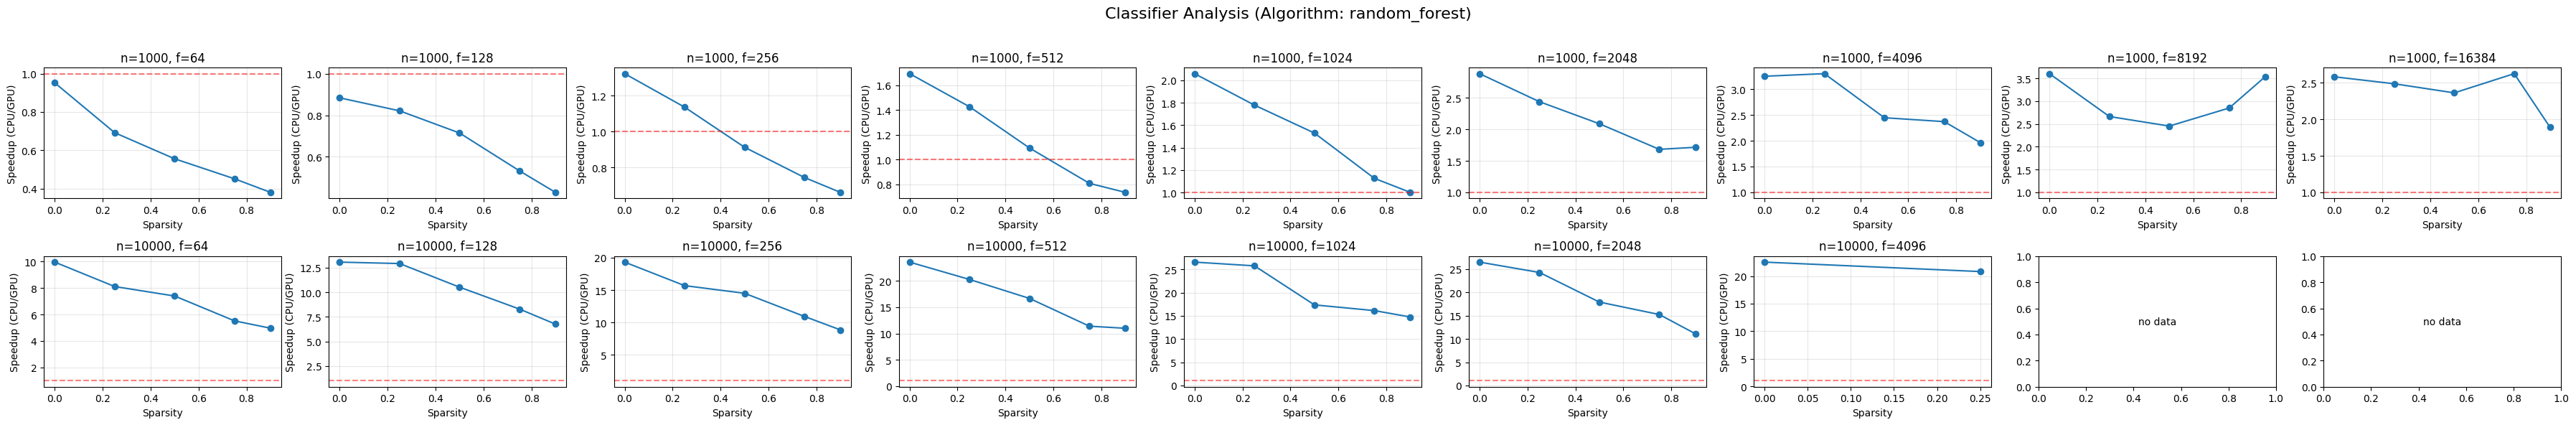

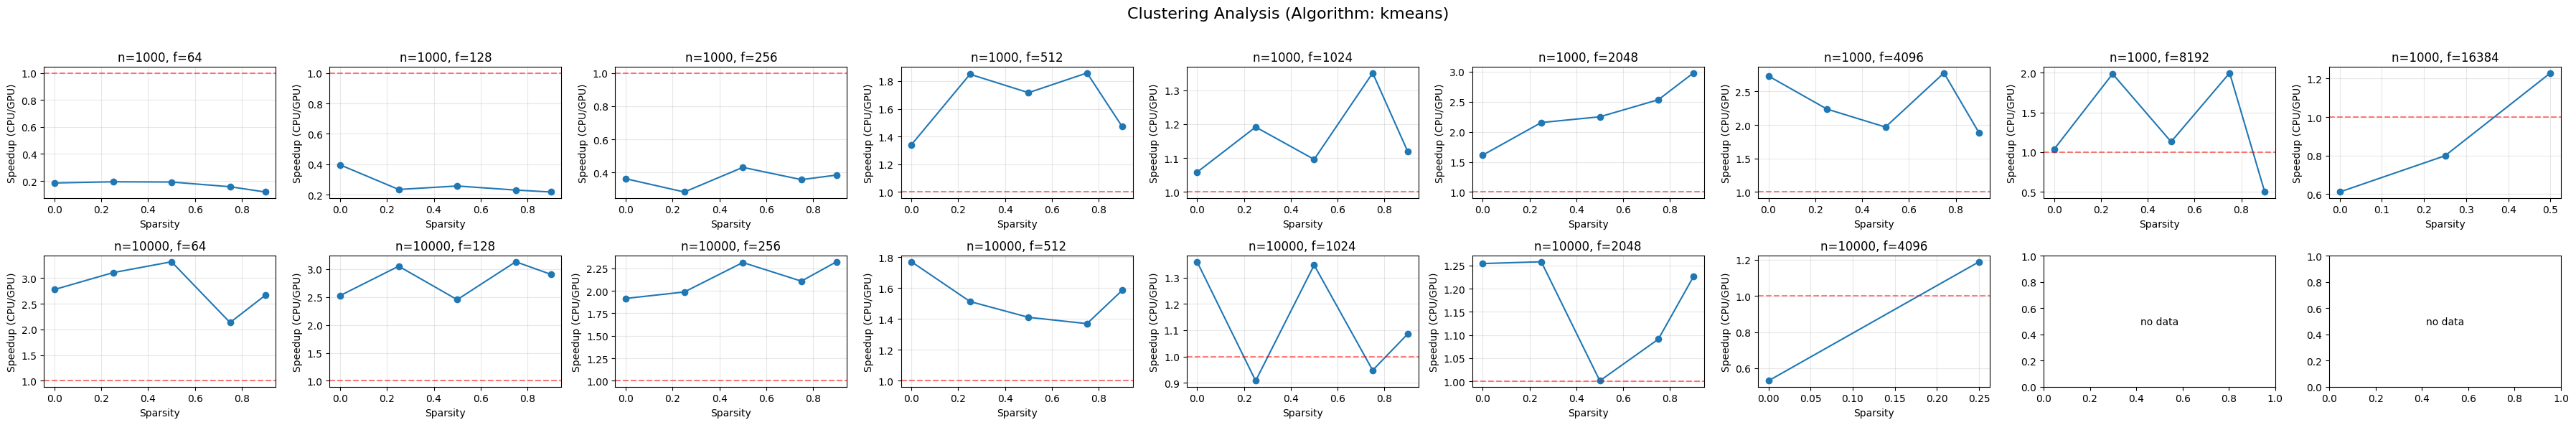

In [ ]:
def compute_speedup(df, algorithm_name, cpu_label='CPU', gpu_label='GPU1'):
    """
    Computes speedup for a specific algorithm.
    """
    # 1. Filter the dataframe for the specific algorithm first
    filtered_df = df[df['algorithm'] == algorithm_name].copy()
    
    if filtered_df.empty:
        print(f"No data found for algorithm: {algorithm_name}")
        return pd.DataFrame()

    # 2. Group by configuration features (excluding algorithm as it's now constant)
    grp = filtered_df.groupby(['n_samples', 'n_features', 'sparsity', 'accelerator'])['mean_time'].mean().reset_index()
    
    # 3. Pivot so CPU and GPU times are side-by-side
    pivot = grp.pivot_table(
        index=['n_samples', 'n_features', 'sparsity'], 
        columns='accelerator', 
        values='mean_time'
    )
    pivot = pivot.reset_index()
    
    # 4. Re-add the algorithm name column for traceability
    pivot['algorithm'] = algorithm_name

    # Ensure hardware columns exist to prevent KeyError
    for col in [cpu_label, gpu_label]:
        if col not in pivot.columns:
            pivot[col] = np.nan

    # 5. Calculate speedup
    pivot[gpu_label] = pivot[gpu_label].replace(0, np.nan)
    pivot['speedup'] = pivot[cpu_label] / pivot[gpu_label]
    
    return pivot

def plot_speedup_grid(df, algorithm_name, title):
    """
    Plots the speedup grid for a specific algorithm.
    """
    # Use the parameter to get specific data
    sp = compute_speedup(df, algorithm_name=algorithm_name)
    sp = sp.dropna(subset=['speedup'])
    
    if sp.empty:
        print(f'No speedup data available for {algorithm_name}')
        return
        
    ns_vals = sorted(sp['n_samples'].unique())
    nf_vals = sorted(sp['n_features'].unique())
    
    # Create subplots based on grid dimensions
    fig, axs = plt.subplots(len(ns_vals), len(nf_vals), 
                            figsize=(4*max(1,len(nf_vals)), 3*max(1,len(ns_vals))), 
                            squeeze=False)
    
    for i, ns in enumerate(ns_vals):
        for j, nf in enumerate(nf_vals):
            ax = axs[i][j]
            subset = sp[(sp['n_samples']==ns) & (sp['n_features']==nf)].sort_values('sparsity')
            
            if subset.empty:
                ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                continue
                
            ax.plot(subset['sparsity'], subset['speedup'], marker='o')
            ax.axhline(1.0, color='red', linestyle='--', alpha=0.5) # Parity line
            ax.set_title(f'n={ns}, f={nf}')
            ax.set_xlabel('Sparsity')
            ax.set_ylabel('Speedup (CPU/GPU)')
            ax.grid(True, alpha=0.3)
            
    fig.suptitle(f"{title} (Algorithm: {algorithm_name})", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# --- Usage Example ---
# Assuming df_classifier and df_clusterer are loaded from your parquet files
plot_speedup_grid(df_classifier, algorithm_name="random_forest", title="Classifier Analysis")
plot_speedup_grid(df_clusterer, algorithm_name="kmeans", title="Clustering Analysis")

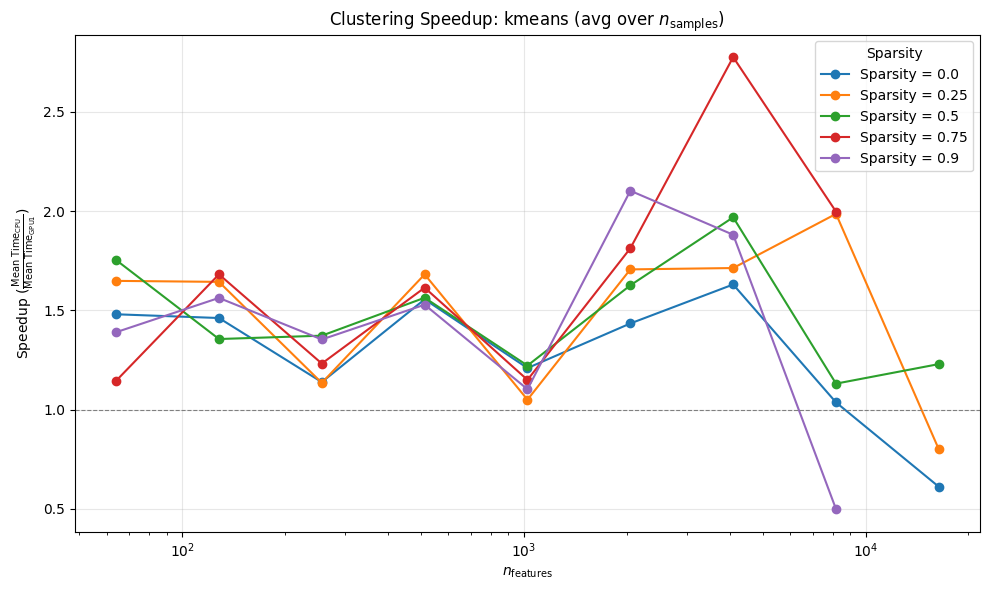

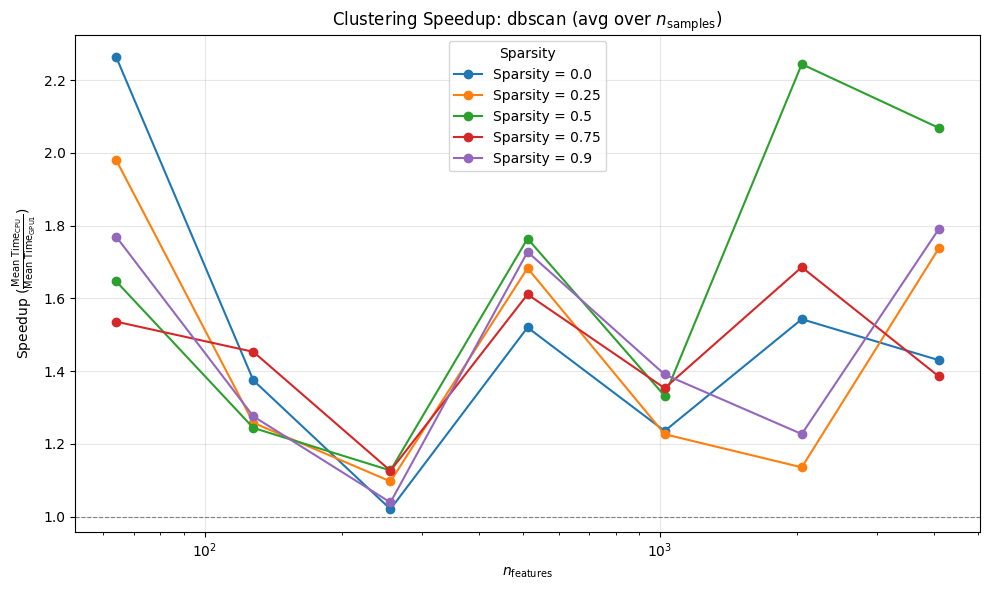

In [ ]:

def plot_speedup_nfeatures_all_sparsity(df, algorithm_name, title):
    # 1. Compute speedup using the algorithm parameter
    sp = compute_speedup(df, algorithm_name=algorithm_name, cpu_label='CPU', gpu_label='GPU1')
    
    sp = sp.dropna(subset=['speedup'])
    if sp.empty:
        print(f'No speedup data available for algorithm "{algorithm_name}"')
        return

    spars_vals = sorted(sp['sparsity'].unique())
    
    # Use subplots to avoid .figure() as per best practices
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for s in spars_vals:
        subset = sp[sp['sparsity'] == s]
        if subset.empty:
            continue
        
        # Aggregate over n_samples
        agg = subset.groupby('n_features')['speedup'].mean().reset_index().sort_values('n_features')
        ax.plot(agg['n_features'], agg['speedup'], marker='o', label=f'Sparsity = {s}')

    # Formatting
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
    
    # Use raw strings for labels to handle backslashes safely
    ax.set_xlabel(r'$n_{\text{features}}$')
    ax.set_ylabel(r'Speedup ($\frac{\text{Mean Time}_{\text{CPU}}}{\text{Mean Time}_{\text{GPU1}}}$)')
    
    # CORRECTED LINE: Use rf"" and double the braces for \text{{samples}}
    ax.set_title(rf"{title}: {algorithm_name} (avg over $n_{{\text{{samples}}}}$)")
    
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(title='Sparsity')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'speedup_{algorithm_name}_nfeatures.png')

# --- Example Usage ---
# For the classifier dataset[cite: 1]:
plot_speedup_nfeatures_all_sparsity(df_classifier, 'random_forest', 'Classifier Speedup')

# For the clustering dataset:
plot_speedup_nfeatures_all_sparsity(df_clusterer, 'kmeans', 'Clustering Speedup')
plot_speedup_nfeatures_all_sparsity(df_clusterer, 'dbscan', 'Clustering Speedup')